### **Time Series Forecasting of AAL Stock Prices Using ARIMA and Deep Learning Models (2010–2025)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from scipy.stats import shapiro

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU

import yfinance as yf

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

### **Loading AAL Stock Data from Yahoo Finance**

In [2]:
stockdata = yf.download('AAL', '2010-01-01')

open_data = stockdata[('Open', 'AAL')].reset_index()
open_data.columns = ['Date', 'Open']
open_data.columns.name = None

open_data.set_index('Date', inplace=True)
open_data.head()

[*********************100%***********************]  1 of 1 completed


,Open
Date,
2010-01-04,4.563
2010-01-05,4.516
2010-01-06,4.893
2010-01-07,4.770
2010-01-08,4.968


In [3]:
validation_split = 0.25

def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return round(rmse,7)

def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return round(mape, 7)

def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return round(smape, 7)

def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return f"{rmse:.7f}"

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Open":scaler.fit_transform(np.array(open_data['Open']).reshape(len(open_data),1)).reshape(len(open_data),)}, index = open_data.index)
df.head()

,Open
Date,
2010-01-04,0.015
2010-01-05,0.014
2010-01-06,0.021
2010-01-07,0.019
2010-01-08,0.023


### **ARIMA Model**

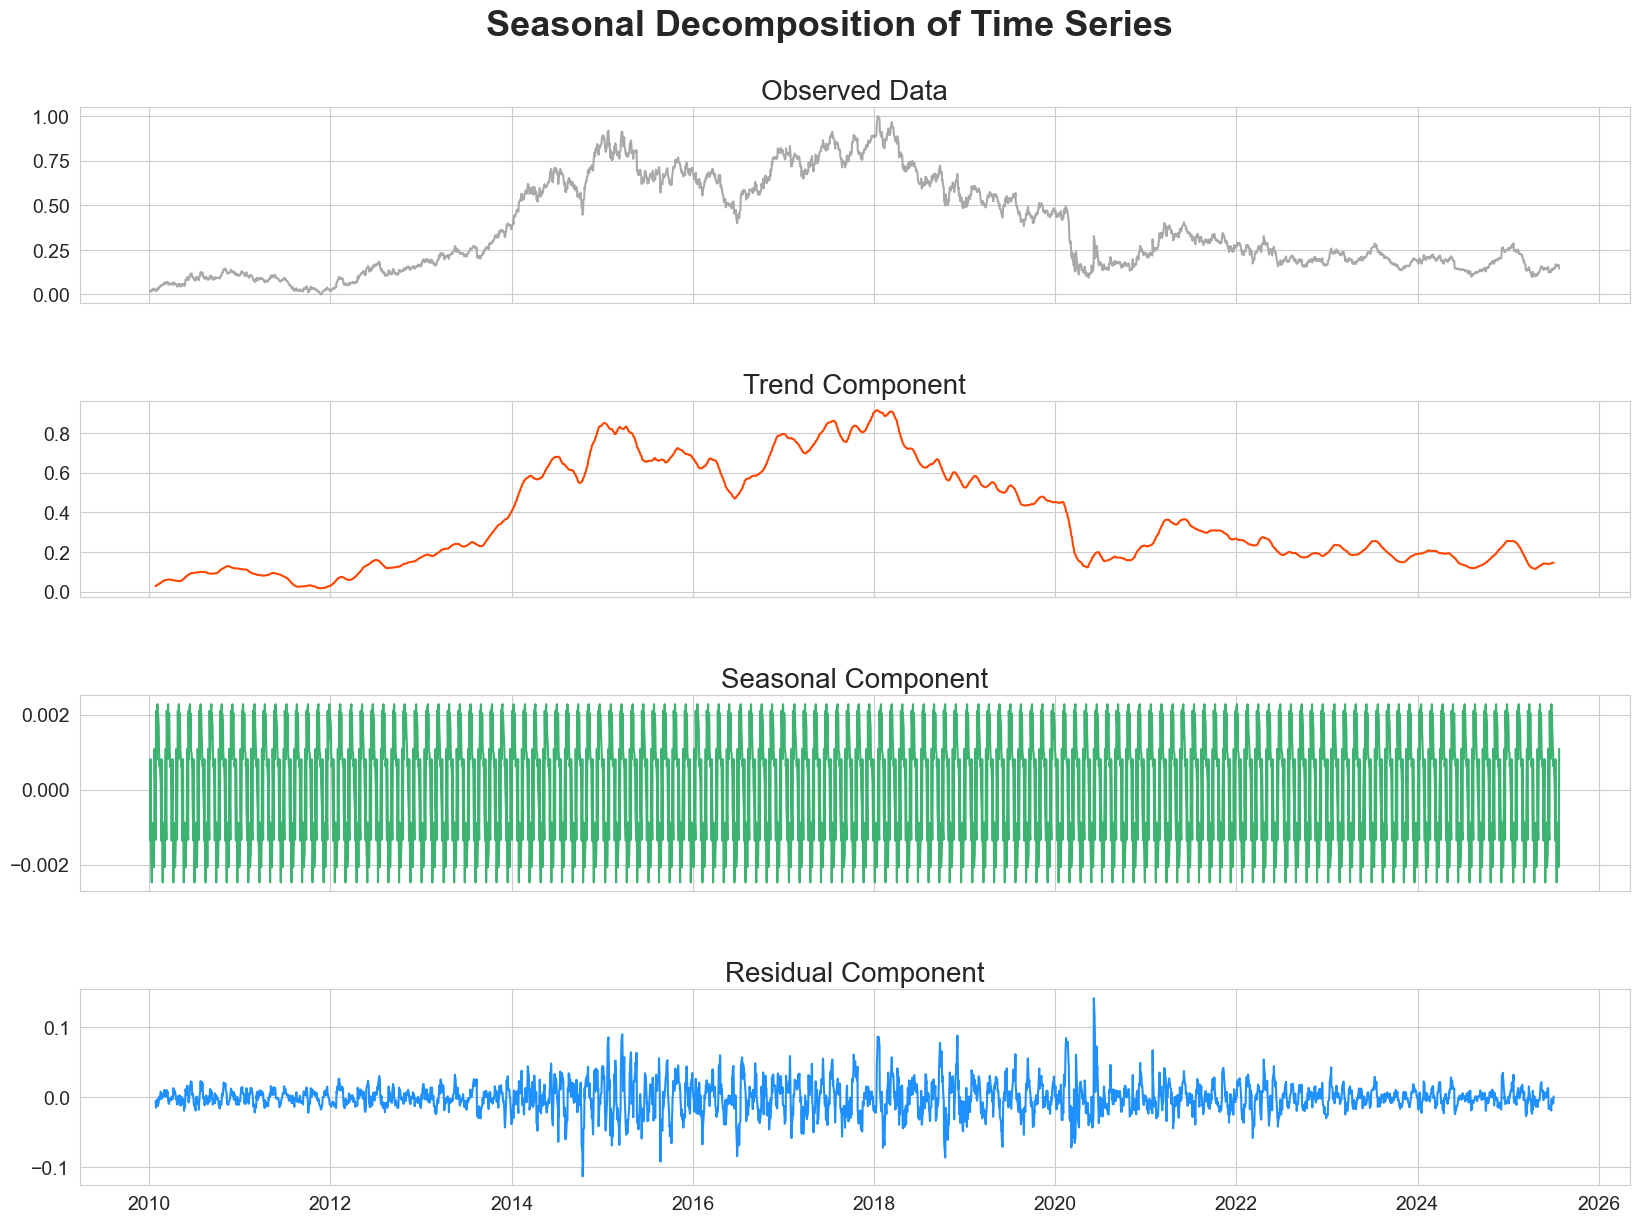

In [5]:
def plot_seasonal_decompose(data, dates, model='additive'):
    
    sns.set_style("whitegrid")
    decomposition = seasonal_decompose(data, model=model, period=30)

    # Plotting
    fig, axes = plt.subplots(4, 1, figsize=(20, 14), sharex=True, gridspec_kw={'hspace': 0.5})

    # Original Series
    axes[0].plot(dates, data, color='darkgray', label='Observed')
    axes[0].set_title('Observed Data', fontsize=20)
    axes[0].grid(True)

    # Trend
    axes[1].plot(dates, decomposition.trend, color='orangered', label='Trend')
    axes[1].set_title('Trend Component', fontsize=20)
    axes[1].grid(True)

    # Seasonality
    axes[2].plot(dates, decomposition.seasonal, color='mediumseagreen', label='Seasonality')
    axes[2].set_title('Seasonal Component', fontsize=20)
    axes[2].grid(True)

    # Residuals
    axes[3].plot(dates, decomposition.resid, color='dodgerblue', label='Residual')
    axes[3].set_title('Residual Component', fontsize=20)
    axes[3].grid(True)

    for ax in axes:
        ax.tick_params(axis='both', labelsize=14)

    plt.suptitle('Seasonal Decomposition of Time Series', fontsize=26, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()

    return decomposition

decompose_result = plot_seasonal_decompose(df['Open'], df.index, model='additive')

In [6]:
def plot_data_properties(data, ts_plot_name="Daily Stock Price of AAL from 2010 to 2025"):

    sns.set_style("whitegrid")

    # --- Time Series Plot ---
    plt.figure(figsize=(18, 4))
    plt.plot(data, color='royalblue', linewidth=2)
    plt.title(ts_plot_name, fontsize=16, fontweight='bold')
    plt.ylabel('Daily Opening Price', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- ACF, PACF, Distribution ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), squeeze=False)

    plot_acf(data, ax=axes[0, 0], lags=50, title="Autocorrelation (ACF)")
    plot_pacf(data, ax=axes[0, 1], lags=50, title="Partial Autocorrelation (PACF)")

    sns.histplot(data, kde=True, ax=axes[0, 2], color='mediumseagreen', bins=30, legend=False)
    axes[0, 2].set_title("Probability Distribution", fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Sales')
    axes[0, 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

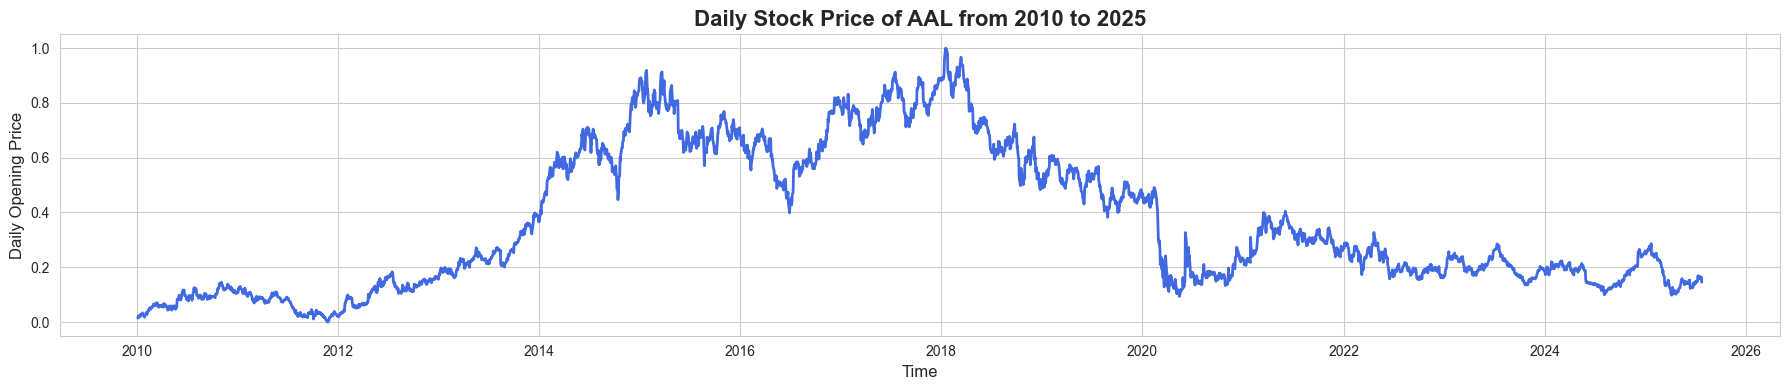

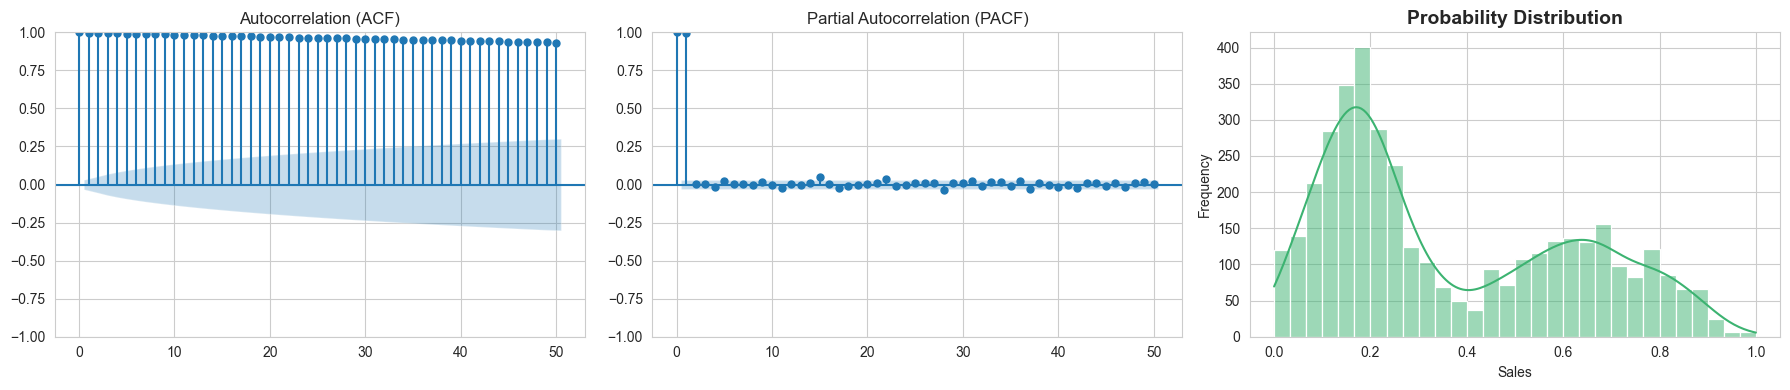

In [7]:
plot_data_properties(df['Open'], 'Daily Stock Price of AAL from 2010 to 2025')

In [8]:
def test_stationarity(data, column='Open'):
    
    if isinstance(data, pd.DataFrame):
        series = data[column].dropna()
    else:
        series = pd.Series(data).dropna()
        
    adf_stat, adf_pval, _, _, _, _ = adfuller(series)
    print("=== Augmented Dickey-Fuller Test (ADF) ===")
    print(f"ADF Statistic : {adf_stat:.4f}")
    print(f"p-value       : {adf_pval:.4f}")
    if adf_pval >= 0.05:
        print("→ Fail to reject H₀: Series is NOT stationary")
    else:
        print("→ Reject H₀: Series is STATIONARY")
    print()

    kpss_stat, kpss_pval, _, _ = kpss(series, regression='c', nlags="auto")
    print("=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===")
    print(f"KPSS Statistic : {kpss_stat:.4f}")
    print(f"p-value        : {kpss_pval:.4f}")
    if kpss_pval <= 0.05:
        print("→ Reject H₀: Series is NOT stationary")
    else:
        print("→ Fail to reject H₀: Series is STATIONARY")

In [9]:
test_stationarity(df)

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -1.7562
p-value       : 0.4024
→ Fail to reject H₀: Series is NOT stationary

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 2.0094
p-value        : 0.0100
→ Reject H₀: Series is NOT stationary


In [10]:
test_stationarity(df['Open'].diff()[1:]) 

=== Augmented Dickey-Fuller Test (ADF) ===
ADF Statistic : -63.0123
p-value       : 0.0000
→ Reject H₀: Series is STATIONARY

=== Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS) ===
KPSS Statistic : 0.2304
p-value        : 0.1000
→ Fail to reject H₀: Series is STATIONARY


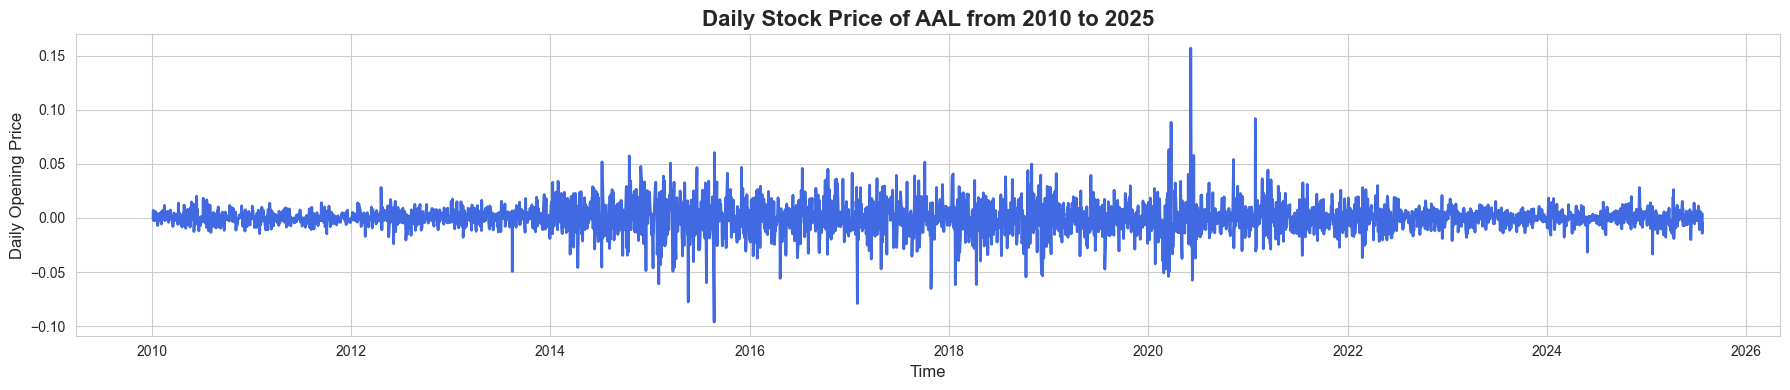

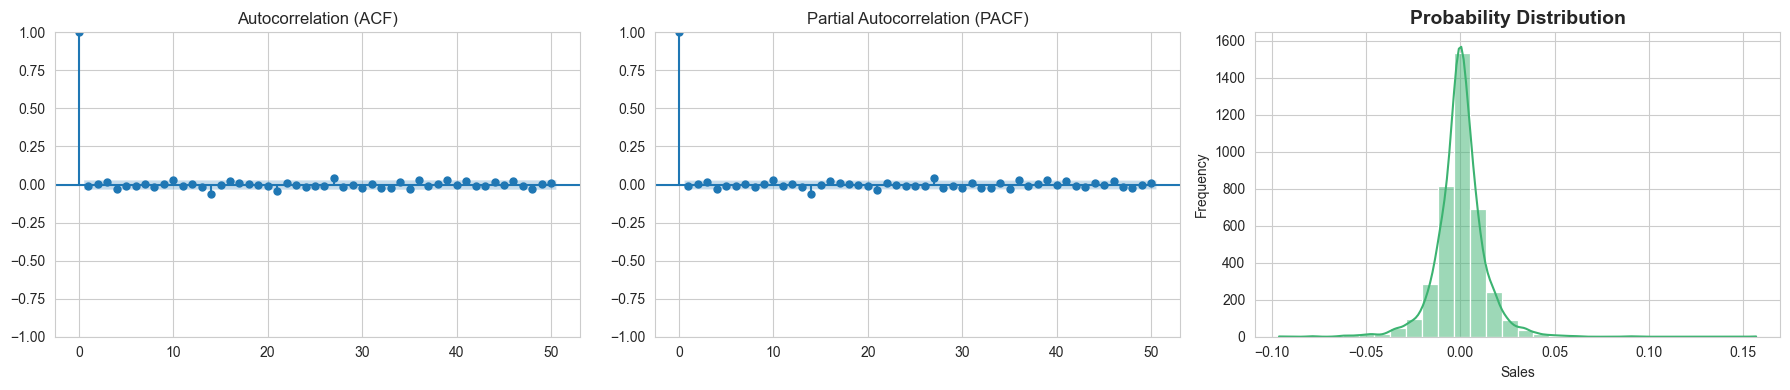

In [11]:
plot_data_properties(df['Open'].diff()[1:], 'Daily Stock Price of AAL from 2010 to 2025')

In [12]:
lb_test = acorr_ljungbox(df['Open'].diff()[1:], lags=[10, 20, 30], return_df=True)
print(lb_test)

    lb_stat  lb_pvalue
10    9.025      0.530
20   28.542      0.097
30   48.486      0.018


In [13]:
def shapiro_normality_test(data):
    
    stat, p_value = shapiro(data)
    mean = np.round(np.mean(data), 3)
    std = np.round(np.std(data), 3)
    
    print(f"Shapiro-Wilk Test Statistic: {stat:.3f}")
    print(f"P-Value: {p_value:.3f}")
    
    if p_value >= 0.05:
        print(f"\033[92mData appears to be normally distributed (X ~ N({mean}, {std})).\033[0m")
    else:
        print(f"\033[91mData does NOT follow a normal distribution (p < 0.05).\033[0m")

shapiro_normality_test(df['Open'].diff()[1:])

Shapiro-Wilk Test Statistic: 0.916
P-Value: 0.000
Data does NOT follow a normal distribution (p < 0.05).


In [14]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [15]:
def best_arima_model(train_data, p, q, d=1):
    best_model_aic = np.inf
    best_model_bic = np.inf
    best_model_hqic = np.inf
    best_model_order = None
    best_model = None
    models = []

    for p_ in p:
        for q_ in q:
            try:
                model = ARIMA(endog=train_data, order=(p_, d, q_)).fit()
                models.append(model)

                no_of_better_metrics = sum([
                    model.aic <= best_model_aic,
                    model.bic <= best_model_bic,
                    model.hqic <= best_model_hqic
                ])

                if no_of_better_metrics >= 2:
                    best_model = model
                    best_model_aic = round(model.aic, 2)
                    best_model_bic = round(model.bic, 2)
                    best_model_hqic = round(model.hqic, 2)
                    best_model_order = (p_, d, q_)

                    print(f"Best so far: ARIMA{best_model_order} | "
                          f"AIC={best_model_aic}, BIC={best_model_bic}, HQIC={best_model_hqic}, "
                          f"Residual Mean={round(np.mean(np.abs(model.resid)), 4)}")

            except Exception as e:
                print(f"Failed for ARIMA({p_},{d},{q_}) → {e}")

    print("\nFinal Best ARIMA Model:")
    print(best_model.summary())

    return best_model, models

In [16]:
best_model, all_models = best_arima_model(df_train, p=range(2), q=range(2))

Best so far: ARIMA(0, 1, 0) | AIC=-16589.01, BIC=-16583.03, HQIC=-16586.86, Residual Mean=0.0097

Final Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 2935
Model:                 ARIMA(0, 1, 0)   Log Likelihood                8295.507
Date:                Sat, 26 Jul 2025   AIC                         -16589.015
Time:                        23:03:50   BIC                         -16583.031
Sample:                             0   HQIC                        -16586.860
                               - 2935                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002   2.28e-06     89.793      0.000       0.000       0.000
Ljung-Box

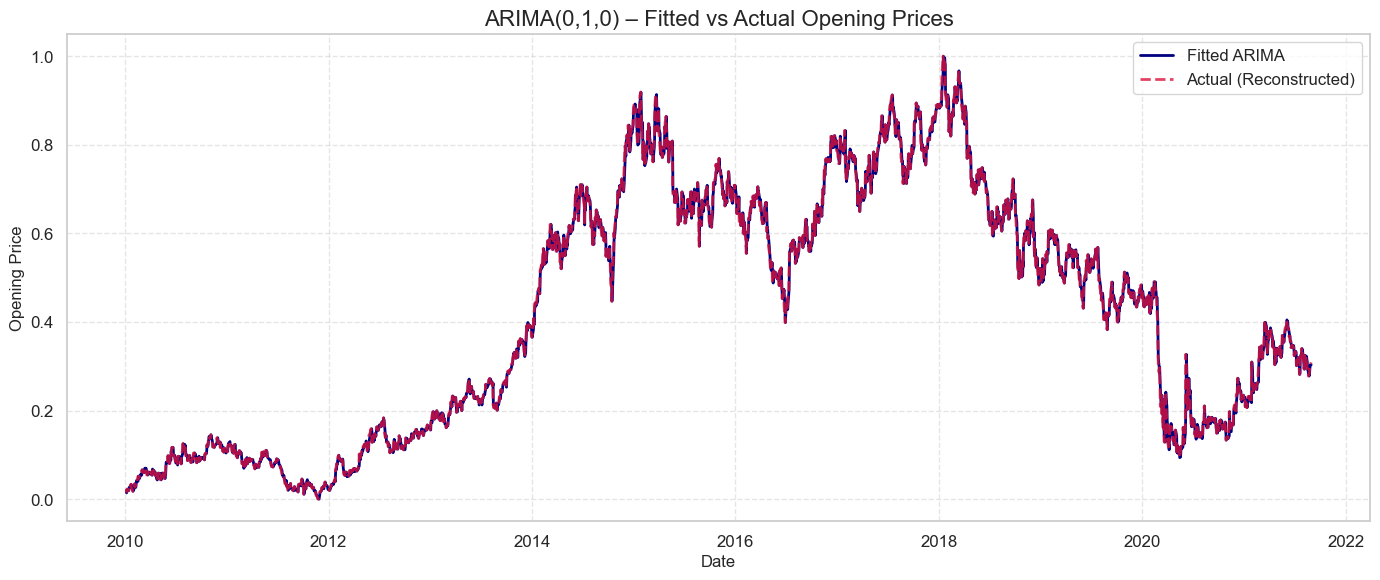

In [17]:
sns.set(style='whitegrid', font_scale=1.1)

df_train['ARIMA'] = np.nan
df_train['diff'] = np.nan

p, d, q = best_model.model.order  

start_label = df_train.index[d]
df_train.loc[start_label:, 'ARIMA'] = best_model.fittedvalues
df_train.loc[start_label:, 'diff'] = best_model.fittedvalues + best_model.resid

plt.figure(figsize=(14, 6))
plt.plot(df_train['ARIMA'], label='Fitted ARIMA', color='navy', linewidth=2)
plt.plot(df_train['diff'], label='Actual (Reconstructed)', color='crimson', linestyle='--', linewidth=2, alpha=0.8)
plt.title(f'ARIMA({p},{d},{q}) – Fitted vs Actual Opening Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

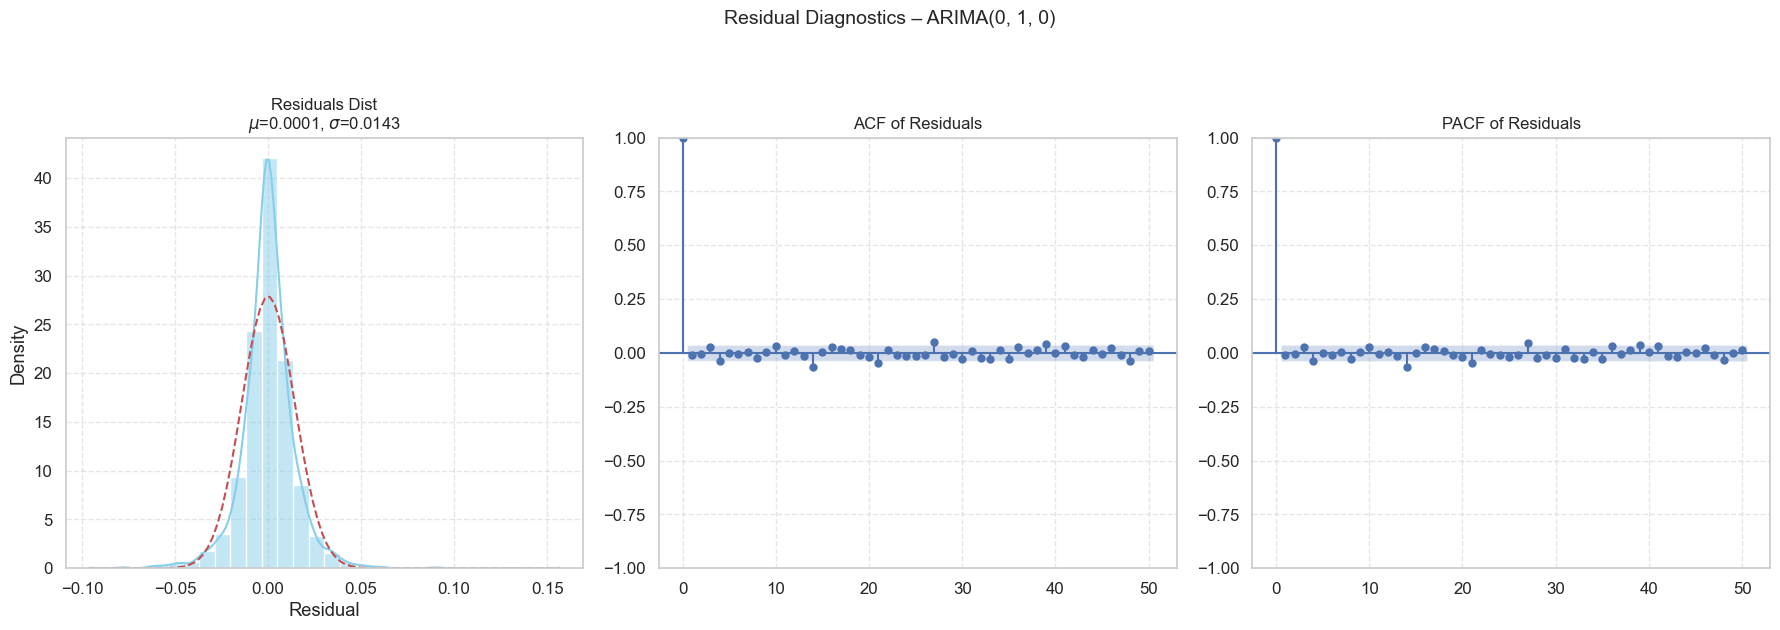

In [18]:
sns.set(style='whitegrid', font_scale=1.1)

resid = best_model.resid
mu, sigma = stats.norm.fit(resid)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

sns.histplot(resid, kde=True, stat="density", bins=30, color='skyblue', ax=axes[0])
x = np.linspace(resid.min(), resid.max(), 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r--')
axes[0].set_title(f'Residuals Dist\n$\mu$={mu:.4f}, $\sigma$={sigma:.4f}', fontsize=12)
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle='--', alpha=0.5)

plot_acf(resid, lags=50, ax=axes[1], alpha=0.05)
axes[1].set_title('ACF of Residuals', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.5)

plot_pacf(resid, lags=50, ax=axes[2], alpha=0.05, method='ywm')
axes[2].set_title('PACF of Residuals', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.5)

plt.suptitle(f'Residual Diagnostics – ARIMA{best_model.model.order}', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

### 1. Residual Distribution
**Interpretation** : Residuals are approximately normally distributed, which supports the validity of your model's assumptions.
### 2. Autocorrelation Function
**Interpretation** : Residuals resemble white noise, indicating the model has captured all systematic patterns from the data.
### 3. Partial Autocorrelation Function
**Interpretation** : Residuals do not show any significant partial autocorrelation, further confirming that your model does not leave behind predictable patterns.

In [19]:
order = best_model.model.order

def recursive_arima_forecast(train_series, test_series, order):
    
    history = train_series.tolist()
    predictions = []

    for i in range(len(test_series)):
        try:
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)[0]
            predictions.append(forecast)
            history.append(test_series[i])
        except Exception as e:
            print(f"Forecast failed at step {i}: {e}")
            predictions.append(np.nan)  

    return predictions

forecast_values = recursive_arima_forecast(df_train['Open'], df_test['Open'], order)

df_forecasted = pd.DataFrame({
    'Forecast': forecast_values
}, index=df_test.index)

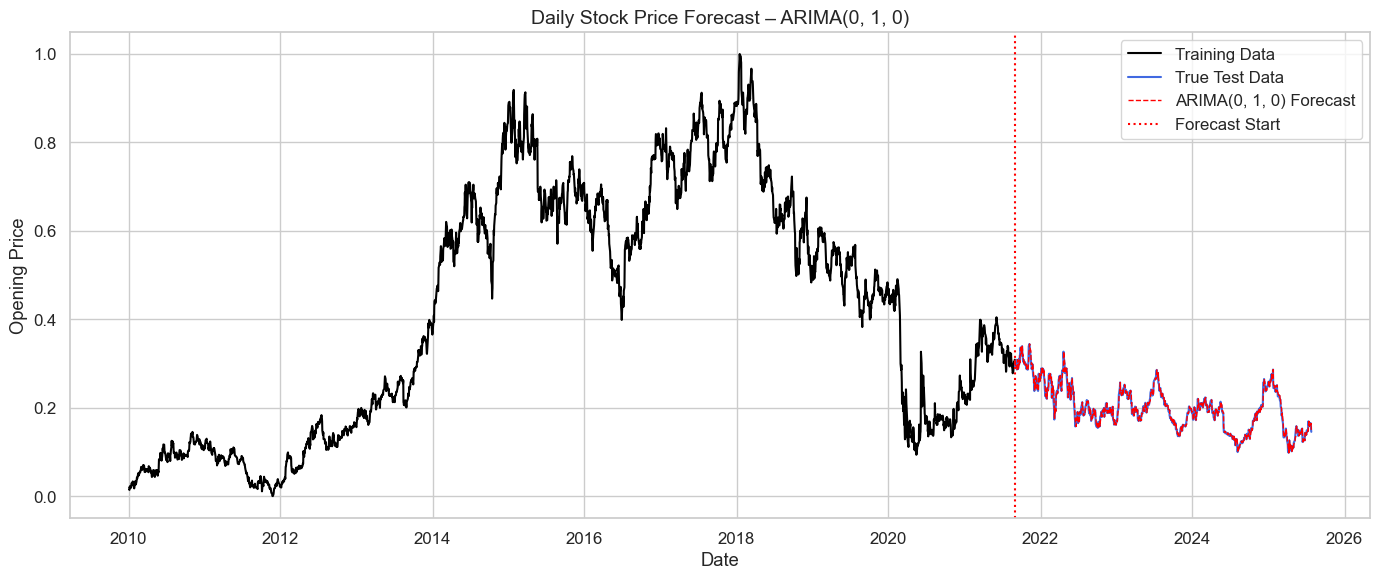

In [20]:
sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(df_train.index, df_train['Open'], label='Training Data', color='black')
plt.plot(df_test.index, df_test['Open'], label='True Test Data', color='royalblue')

plt.plot(df_forecasted.index, df_forecasted['Forecast'], label=f'ARIMA{order} Forecast', color='red', linestyle='--', linewidth=1)

plt.axvline(x=df_test.index[0], color='red', linestyle=':', label='Forecast Start')
plt.title(f'Daily Stock Price Forecast – ARIMA{order}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Opening Price')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
rmse_arima = RMSE(df_test['Open'].tolist(), forecast_values)
mape_arima = MAPE(df_test['Open'].tolist(), forecast_values)
smape_arima = SMAPE(df_test['Open'].tolist(), forecast_values)
msle_arima = MSLE(df_test['Open'].tolist(), forecast_values)

Metrics = {"RMSE_ARIMA": rmse_arima, "MAPE_ARIMA": mape_arima, "SMAPE_ARIMA": smape_arima,"MSLE_ARIMA": msle_arima}
Metrics

{'RMSE_ARIMA': 0.0079368,
 'MAPE_ARIMA': 2.9485849,
 'SMAPE_ARIMA': 2.9413366,
 'MSLE_ARIMA': '0.0000427'}

### **RNN Model**

In [22]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [23]:
train_data = df_train.values
test_data = df_test.values

In [24]:
x_train = []
y_train = []

for i in range(60, len(train_data)):

    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [25]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(32, return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(16))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - loss: 0.0793
Epoch 2/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.0035
Epoch 3/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - loss: 0.0025
Epoch 4/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.0021
Epoch 5/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.0022


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


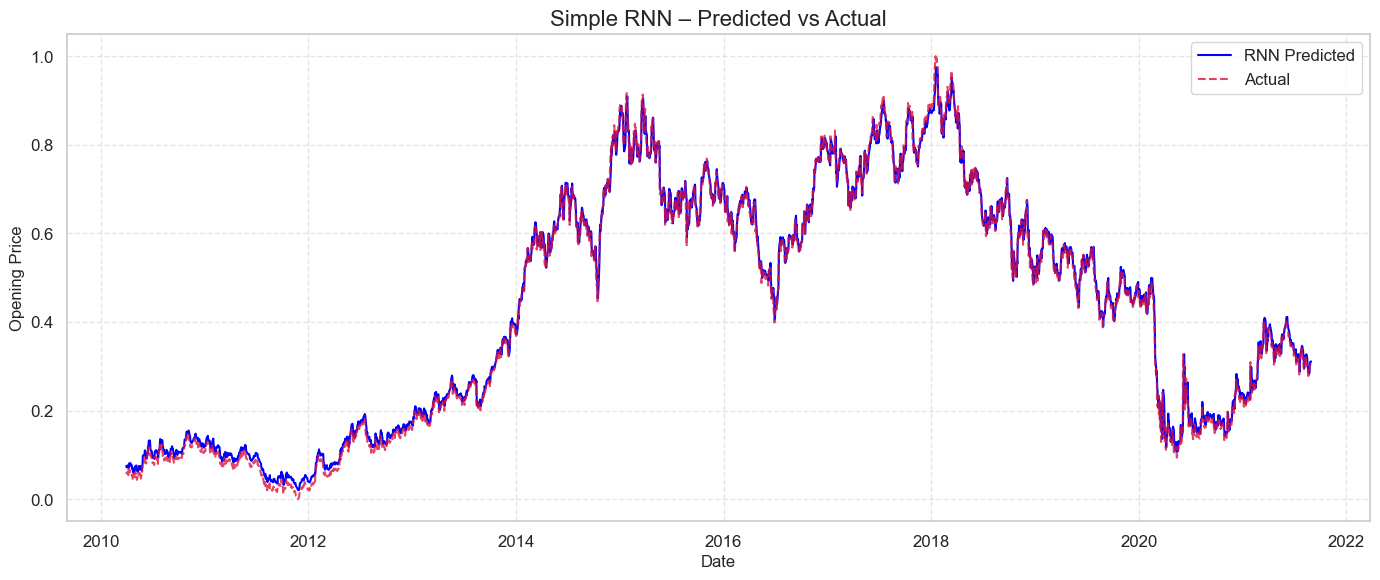

In [26]:
rnn_train_predictions = rnn_model.predict(x_train)

rnn_train_df = pd.DataFrame({
    'Date': df_train.index[60:],  
    'RNN_Predicted': rnn_train_predictions.flatten(),
    'Actual': y_train.flatten()
})
rnn_train_df.set_index('Date', inplace=True)

sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(rnn_train_df['RNN_Predicted'], label='RNN Predicted', color='blue', linewidth=1.5)
plt.plot(rnn_train_df['Actual'], label='Actual', color='crimson', linestyle='--', linewidth=1.5, alpha=0.8)

plt.title('Simple RNN – Predicted vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [27]:
full_test_data = np.concatenate((train_data[-60:], test_data), axis=0)

x_test = []
y_test = []

for i in range(60, len(full_test_data)):
    x_test.append(full_test_data[i-60:i, 0])
    y_test.append(full_test_data[i, 0])

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

rnn_predictions = rnn_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


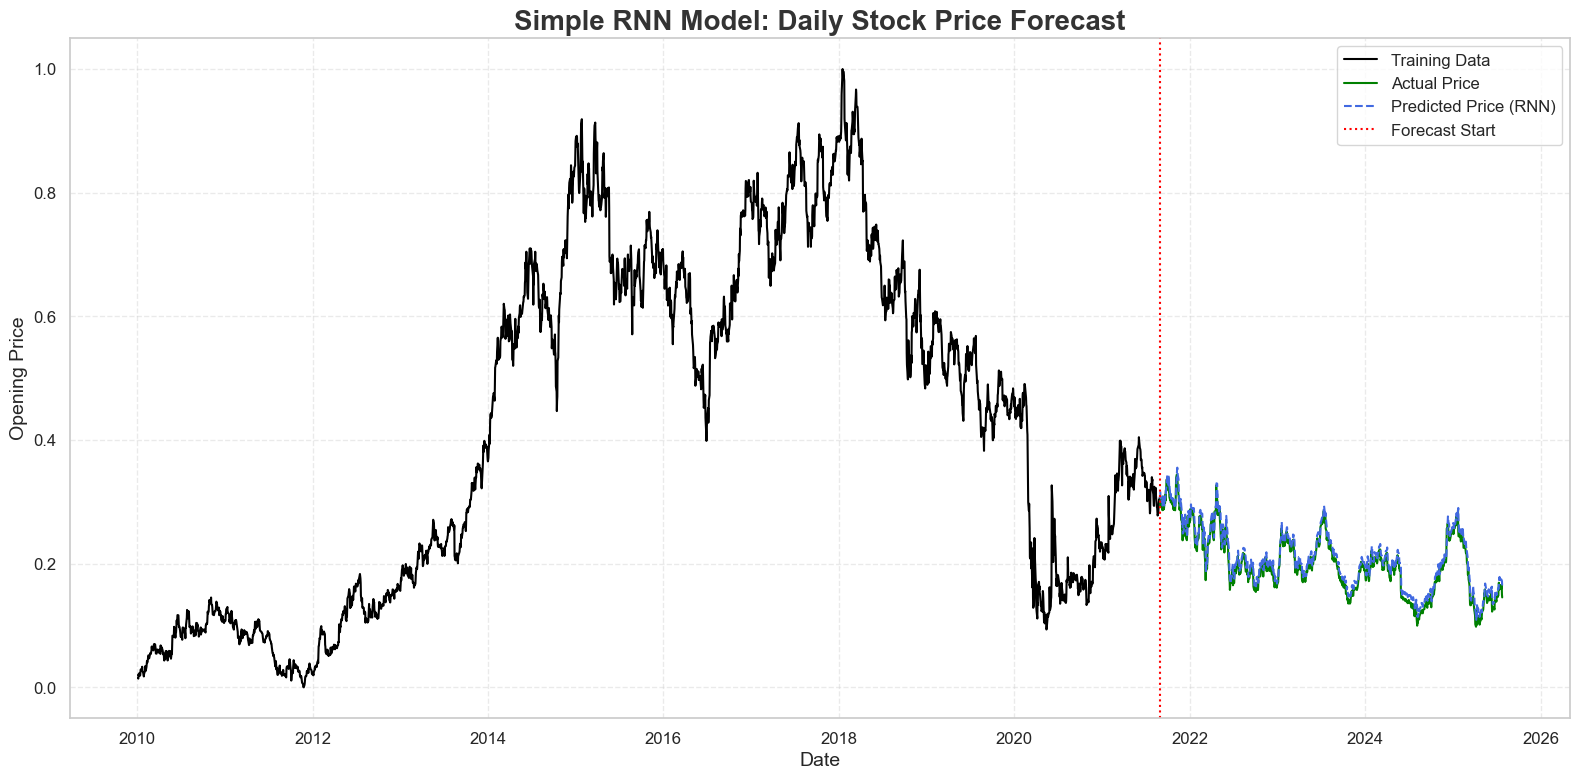

In [28]:
train = df_train.copy()
valid = df_test.copy()

valid['Predictions'] = rnn_predictions  

sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))
plt.title('Simple RNN Model: Daily Stock Price Forecast', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)

plt.plot(train['Open'], label='Training Data', color='black', linewidth=1.5)
plt.plot(valid['Open'], label='Actual Price', color='green', linewidth=1.5)
plt.plot(valid['Predictions'], label='Predicted Price (RNN)', color='royalblue', linestyle='--', linewidth=1.5)

plt.axvline(x=valid.index[0], color='red', linestyle=':', label='Forecast Start')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [29]:
rmse_rnn = RMSE(y_test, rnn_predictions.flatten())
mape_rnn = MAPE(y_test, rnn_predictions.flatten())
smape_rnn = SMAPE(y_test, rnn_predictions.flatten())
msle_rnn = MSLE(y_test, rnn_predictions.flatten())

metrics_rnn = {
    "RMSE_RNN": rmse_rnn,
    "MAPE_RNN": mape_rnn,
    "SMAPE_RNN": smape_rnn,
    "MSLE_RNN": msle_rnn
}

metrics_rnn

{'RMSE_RNN': 0.0119656,
 'MAPE_RNN': 5.463222,
 'SMAPE_RNN': 5.2585245,
 'MSLE_RNN': '0.0000989'}

### **LSTM Model** 

In [43]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [44]:
train_data = df_train.values
test_data = df_test.values

In [45]:
x_train = []
y_train = []

for i in range(60, len(train_data)):

    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [46]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(1))                   

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 56s 19ms/step - loss: 0.0062
Epoch 2/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - loss: 0.0023
Epoch 3/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 79s 22ms/step - loss: 0.0023
Epoch 4/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 62s 22ms/step - loss: 0.0020
Epoch 5/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 62s 22ms/step - loss: 0.0018


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


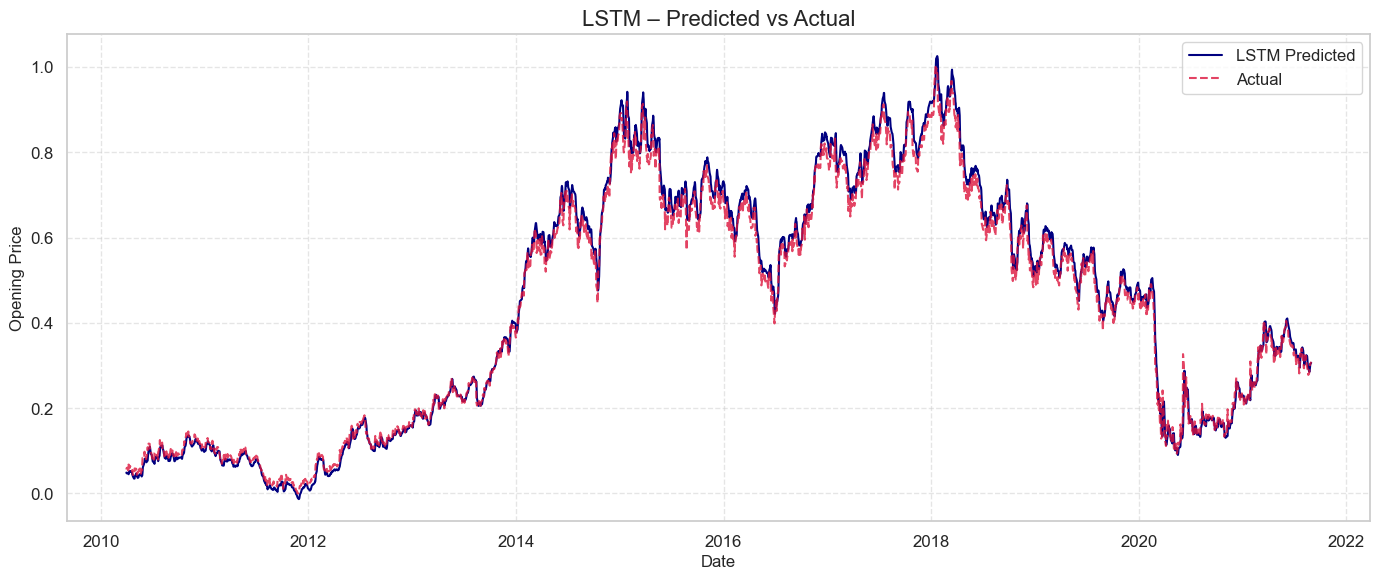

In [47]:
train_predictions = model.predict(x_train)

lstm_train_df = pd.DataFrame({
    'Date': df_train.index[60:],
    'LSTM_Predicted': train_predictions.flatten(),
    'Actual': y_train.flatten()
})
lstm_train_df.set_index('Date', inplace=True)

sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(lstm_train_df['LSTM_Predicted'], label='LSTM Predicted', color='navy', linewidth=1.5)
plt.plot(lstm_train_df['Actual'], label='Actual', color='crimson', linestyle='--', linewidth=1.5, alpha=0.8)

plt.title('LSTM – Predicted vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [48]:
full_test_data = np.concatenate((train_data[-60:], test_data), axis=0)

x_test = []
y_test = []

for i in range(60, len(full_test_data)):
    x_test.append(full_test_data[i-60:i, 0])  
    y_test.append(full_test_data[i, 0])      

x_test = np.array(x_test)
y_test = np.array(y_test) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


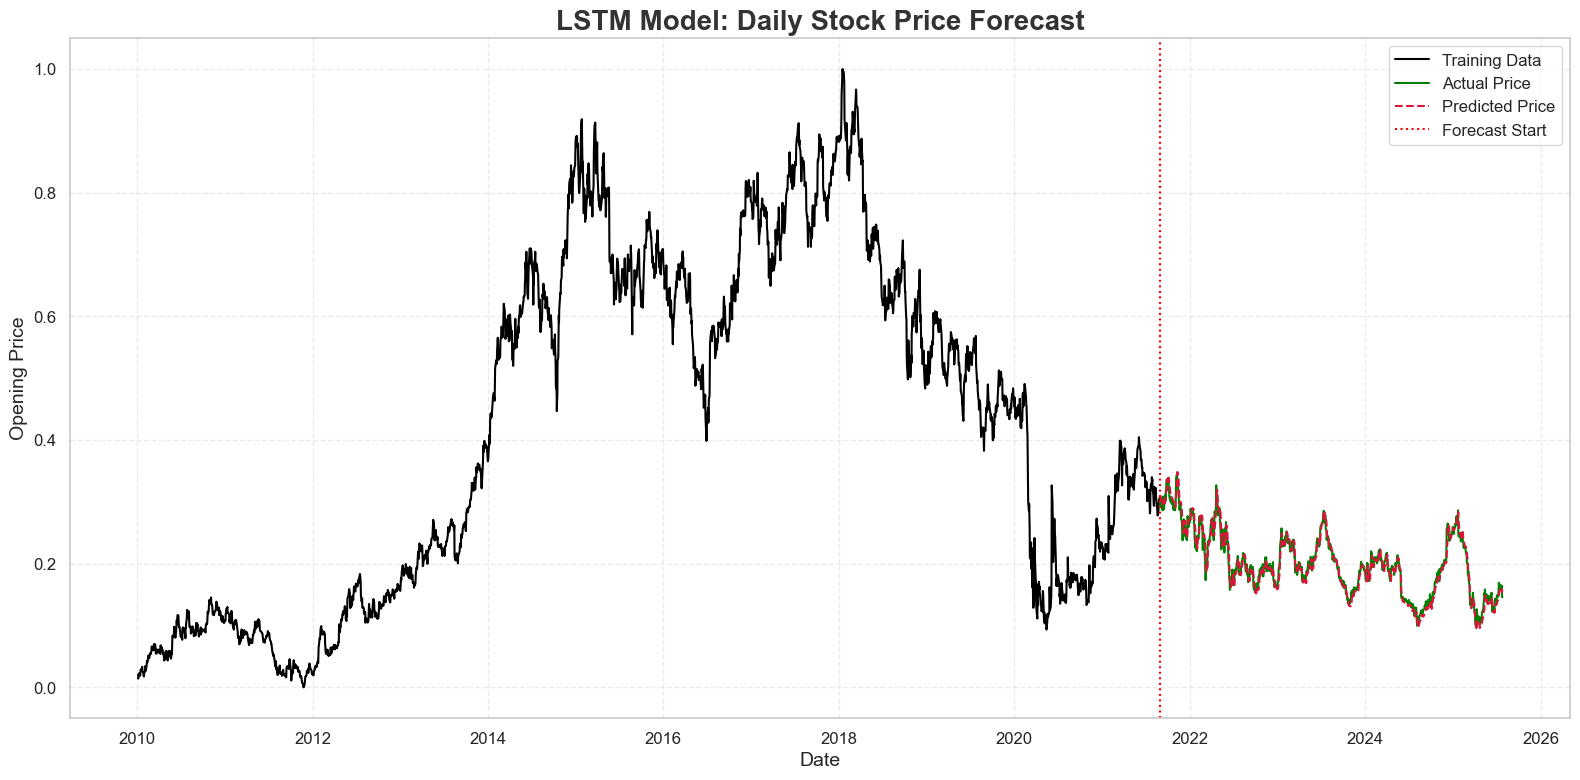

In [49]:
train = df_train.copy()
valid = df_test.copy()
valid['Predictions'] = predictions

sns.set_style("whitegrid")

plt.figure(figsize=(16, 8))

plt.title('LSTM Model: Daily Stock Price Forecast', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)

plt.plot(train['Open'], label='Training Data', color='black', linewidth=1.5)

plt.plot(valid['Open'], label='Actual Price', color='green', linewidth=1.5)

plt.plot(valid['Predictions'], label='Predicted Price', color='crimson', linestyle='--', linewidth=1.5)
plt.axvline(x=valid.index[0], color='red', linestyle=':', label='Forecast Start')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()

plt.show()

In [50]:
rmse_LSTM = RMSE(y_test, predictions.flatten())
mape_LSTM = MAPE(y_test, predictions.flatten())
smape_LSTM = SMAPE(y_test, predictions.flatten())
msle_LSTM = MSLE(y_test, predictions.flatten())

Metrics = {
    "RMSE_LSTM": rmse_LSTM, 
    "MAPE_LSTM": mape_LSTM, 
    "SMAPE_LSTM": smape_LSTM, 
    "MSLE_LSTM": msle_LSTM
}

Metrics

{'RMSE_LSTM': 0.0103623,
 'MAPE_LSTM': 4.1511316,
 'SMAPE_LSTM': 4.1885945,
 'MSLE_LSTM': '0.0000732'}

### **GRU Model**

In [59]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [60]:
train_data = df_train.values
test_data = df_test.values

In [61]:
x_train = []
y_train = []

for i in range(60, len(train_data)):

    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [62]:
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(64, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(32))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 104s 35ms/step - loss: 0.0069
Epoch 2/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - loss: 0.0025
Epoch 3/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - loss: 0.0021
Epoch 4/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - loss: 0.0021
Epoch 5/5
2875/2875 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - loss: 0.0015


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


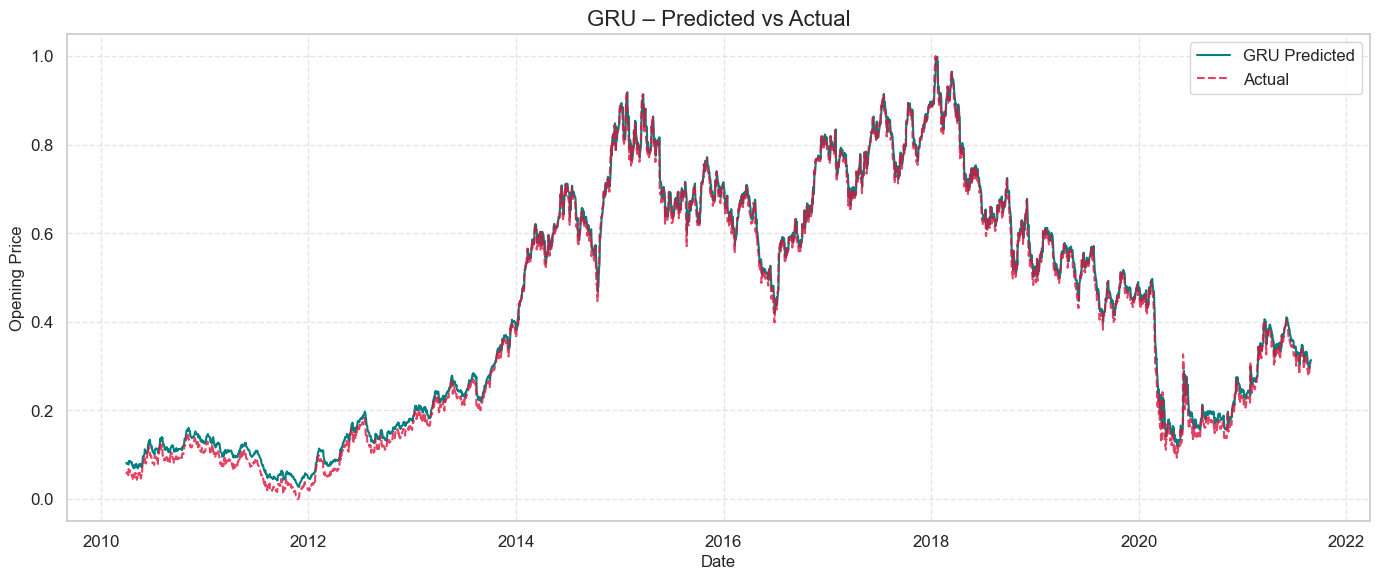

In [63]:
gru_train_predictions = gru_model.predict(x_train)

gru_train_df = pd.DataFrame({
    'Date': df_train.index[60:], 
    'GRU_Predicted': gru_train_predictions.flatten(),
    'Actual': y_train.flatten()
})
gru_train_df.set_index('Date', inplace=True)

sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(gru_train_df['GRU_Predicted'], label='GRU Predicted', color='teal', linewidth=1.5)
plt.plot(gru_train_df['Actual'], label='Actual', color='crimson', linestyle='--', linewidth=1.5, alpha=0.8)

plt.title('GRU – Predicted vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [64]:
full_test_data = np.concatenate((train_data[-60:], test_data), axis=0)

x_test = []
y_test = []

for i in range(60, len(full_test_data)):
    x_test.append(full_test_data[i-60:i, 0])  
    y_test.append(full_test_data[i, 0])       

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

gru_predictions = gru_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


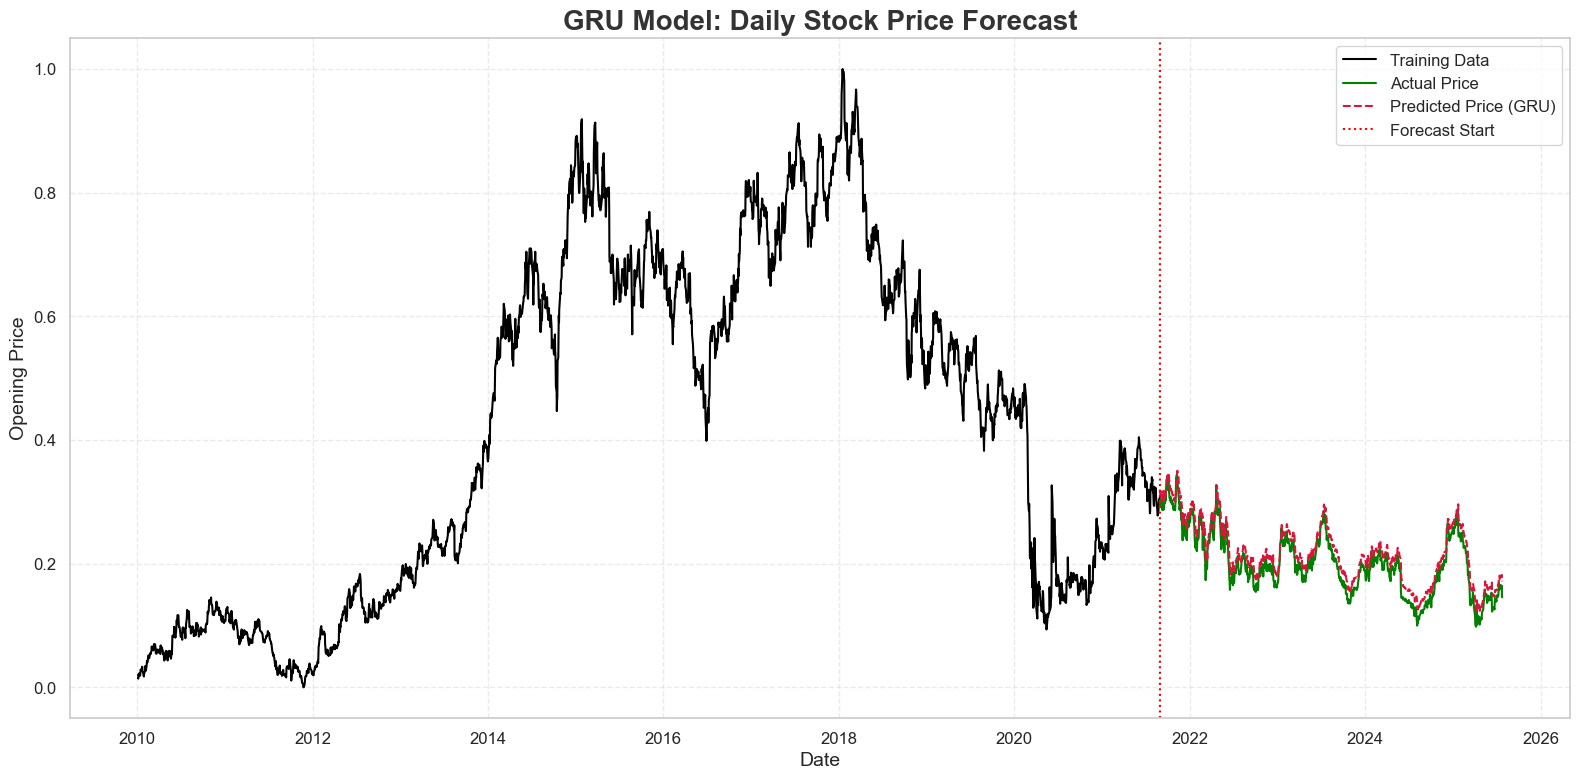

In [65]:
train = df_train.copy()
valid = df_test.copy()

valid['Predictions'] = gru_predictions 

sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

plt.title('GRU Model: Daily Stock Price Forecast', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)

plt.plot(train['Open'], label='Training Data', color='black', linewidth=1.5)
plt.plot(valid['Open'], label='Actual Price', color='green', linewidth=1.5)
plt.plot(valid['Predictions'], label='Predicted Price (GRU)', color='crimson', linestyle='--', linewidth=1.5)

plt.axvline(x=valid.index[0], color='red', linestyle=':', label='Forecast Start')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


In [66]:
y_true = df_test['Open'].values.flatten()
y_pred = gru_predictions.flatten()

rmse_gru = RMSE(y_true, y_pred)
mape_gru = MAPE(y_true, y_pred)
smape_gru = SMAPE(y_true, y_pred)
msle_gru = MSLE(y_true, y_pred)

gru_metrics = {
    "RMSE_GRU": rmse_gru,
    "MAPE_GRU": mape_gru,
    "SMAPE_GRU": smape_gru,
    "MSLE_GRU": msle_gru
}

gru_metrics

{'RMSE_GRU': 0.0186289,
 'MAPE_GRU': 9.2339927,
 'SMAPE_GRU': 8.6970831,
 'MSLE_GRU': '0.0002408'}

### 📊 **Conclusion: Stock Price Forecasting for AAL (2010–2025)**

This project involved building and evaluating multiple time series forecasting models on **American Airlines (AAL)** stock opening prices from **2010 to 2025**. The models evaluated include **ARIMA**, **Simple RNN**, **LSTM**, and **GRU** architectures.

---

### ✅ **1. Model Performance Summary (on Test Set)**

| Model     | RMSE ↓     | MAPE (%) ↓ | SMAPE (%) ↓ | MSLE ↓        |
| --------- | ---------- | ---------- | ----------- | ------------- |
| **ARIMA** | **0.0079** | **2.95**   | **2.94**    | **0.0000427** |
| LSTM      | 0.0104     | 4.15       | 4.19        | 0.0000732     |
| RNN       | 0.0120     | 5.46       | 5.26        | 0.0000989     |
| GRU       | 0.0186     | 9.23       | 8.70        | 0.0002408     |

---

### 🧠 **2. Key Insights**

* **ARIMA** outperformed all deep learning models across all metrics. This suggests the data is **more linear/stationary**, and ARIMA effectively captures the trend and seasonality with low complexity.

* **LSTM** was the best among the deep learning models, with better generalization than RNN and GRU. It handled temporal dependencies well but still underperformed compared to ARIMA.

* **Simple RNN** performed reasonably well, but lacks the memory capacity of LSTM to capture long-term patterns.

* **GRU**, while faster and simpler, had the **least accurate** performance in this case.

---

### 📌 **3. Recommendations**

* For **short-term forecasting of AAL stock prices**, **ARIMA is the best choice** given its simplicity and high accuracy.

* For **more complex datasets with nonlinear patterns** (e.g., multi-stock or high volatility), LSTM or GRU may become more competitive.

* Incorporate **external features** (like volume, news sentiment, or macroeconomic indicators) to enhance deep learning models.

---

### 🎯 **Final Verdict**

> ✅ **ARIMA(0,1,0)** is the most reliable and accurate model for forecasting AAL opening prices from 2010 to 2025.
> Deep learning models showed potential, but require more complex input features for significant gains.